## Experiment Setup

### Random seed / PyTorch / CUDA related

In [1]:
import time
import datetime
import os
import sys
import itertools

# Use Google Colab
use_colab = True

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')
    
    # If there's a package I need to install separately, do it here
    !pip install pyro-ppl

    # cd to the appropriate working directory under my Google Drive
    %cd 'drive/My Drive/Colab Notebooks/bayesian-dl-experiments'
    
    # List the directory contents
    !ls

# IPython reloading magic
%load_ext autoreload
%autoreload 2

# Random seeds
# Based on https://pytorch.org/docs/stable/notes/randomness.html
random_seed = 682

### Third party libraries (NumPy, PyTorch, Pyro)

In [2]:
# Third party libraries import
import numpy as np
import torch
import pyro
import matplotlib.pyplot as plt

# Print version information
print("Python Version: " + sys.version)
print("NumPy Version: " + np.__version__)
print("PyTorch Version: " + torch.__version__)
print("Pyro Version: " + pyro.__version__)

Python Version: 3.8.0 (v3.8.0:fa919fdf25, Oct 14 2019, 10:23:27) 
[Clang 6.0 (clang-600.0.57)]
NumPy Version: 1.17.4
PyTorch Version: 1.4.0a0+328ec54
Pyro Version: 1.0.0


In [3]:
# More imports...
from torch import nn, optim
from torch.utils.data import random_split, DataLoader, RandomSampler
import torchvision
import torchvision.transforms as transforms
from pyro.infer import SVI, Trace_ELBO, HMC, MCMC

# Import model and dataset classes from ronald_bdl
from ronald_bdl import models, datasets

# pyplot setting
%matplotlib inline

# torch.device / CUDA Setup
use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')

    torch.backends.cudnn.deterministic = True
    
    # Disable 'benchmark' mode
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    use_pin_memory = True # Faster Host to GPU copies with page-locked memory

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False

### Variable settings

#### Data prep

In [4]:
# Dataset to use
uci_dataset_name = 'bostonHousing'

# Set the proportion of the original dataset to be available as a whole
subset_proportions = [1]

# Proportion of the dataset to be used for training
dataset_train_size = 0.8

# Number of dataset splits
n_splits = 10

#### NN settings

In [5]:
# Fully-Connected network hidden layers
network_hidden_dims = [50, 100]
network_hidden_layers = [1, 3, 5]

# Dropout
dropout_rates = [0.1, 0.3, 0.5, 0.7]

# Regularization strengths
reg_strengths = [0.05]


### Training setup

In [6]:
# Epochs
n_epochs = [10, 100, 1000]

# Optimizer learning rate
learning_rate = 0.01 # PyTorch default value is 0.001

# Training data batch sizes
if uci_dataset_name in ('protein-tertiary-structure'): # Note: 45730 rows originally
    n_training_batch = 512
elif uci_dataset_name in ('yacht', 'bostonHousing'):
    n_training_batch = 256

# Number of test predictions (for each data point)
n_prediction = 500

# Mean Squared Error for loss function to minimize
objective = nn.MSELoss()

# Test start time
test_start_time = datetime.datetime.today().strftime('%Y%m%d%H%M')

## Train the network

In [8]:
for subset_prop, hidden_dim, n_hidden, dropout_rate, reg_strength, n_epoch in itertools.product(
    subset_proportions,
    network_hidden_dims, network_hidden_layers,
    dropout_rates, reg_strengths,
    n_epochs,
):
    # Reset the random number generator for each method (to produce identical results)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    pyro.set_rng_seed(random_seed)

    # Print parameter combinations being tested
    print(
        "subset %f, n_hidden %d, hidden_dim %d, dropout_rate %f, reg_strength %f"
        % (subset_prop, n_hidden, hidden_dim, dropout_rate, reg_strength))
    
    print("n_epoch %d" % n_epoch)
    print()

    """
    Results file storage
    """

    # Create directory to store results for the current test configuration
    test_results_path = os.path.join(
        './test_results',
        'error_convergence_1',
        uci_dataset_name,
        test_start_time,
        (
            str(subset_prop) 
            + '_' + str(hidden_dim) 
            + '_' + str(n_hidden) 
            + '_' + str(dropout_rate) 
            + '_' + str(reg_strength)
            + '_' + str(n_epoch)),
    )
    
    os.makedirs(test_results_path, exist_ok=True)
    
    test_results_rmse_mc_path = os.path.join(
        test_results_path,
        "rmse_mc.txt"
    )
    
    test_results_lls_mc_path = os.path.join(
        test_results_path,
        "lls_mc.txt"
    )

    test_results_rmse_non_mc_path = os.path.join(
        test_results_path,
        "rmse_non_mc.txt"
    )    

    """
    Dataset multiple splits prep
    """

    # Prepare new subset of the original dataset
    subset = datasets.UCIDatasets(
        uci_dataset_name, root_dir='./datasets_files', 
        limit_size=subset_prop, transform=None, download=True)

    # Determine sizes of training and testing set
    train_size = int(dataset_train_size * len(subset))
    test_size = len(subset) - train_size
    
    # Print the size of the subset
    print("subset size = " + str((len(subset), subset.n_features)))
    print("training set size = %d" % train_size)
    print("test set size = %d" % test_size)
    print()
    
    # Prepare multiple sets of random train-test splits 
    # to test the parameter combination
    subset_splits = []

    for _ in range(n_splits):
        train, test = random_split(subset, lengths=[train_size, test_size])
        subset_splits.append((train, test))

    # Try learning with different splits
    for s, (train, test) in enumerate(subset_splits):

        """
        Training
        """
      
        print('Training with split %d' % s)

        train_loader = DataLoader(train, batch_size=n_training_batch, pin_memory=use_pin_memory)

        # Prepare network
        network = models.FCNetMCDropout(
          input_dim=subset.n_features, 
          output_dim=subset.n_targets,
          hidden_dim=hidden_dim,
          n_hidden=n_hidden,
          dropout_rate=dropout_rate,
          dropout_type='bernoulli',
        )

        # Send the whole model to the selected torch.device
        network.to(torch_device)

        # Model to train mode
        network.train()

        # Adam optimizer
        # https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam
        # NOTE: Need to set L2 regularization from here
        optimizer = optim.Adam(
            network.parameters(),
            lr=learning_rate,
            weight_decay=reg_strength, # L2 regularization
        )

        # Record training start time (for this split)
        tic = time.time()

        for epoch in range(n_epoch): # loop over the dataset multiple times
            # Mini-batches
            for data in train_loader:
                # get the inputs; data is a list of [inputs, labels]
                inputs, targets = data

                # Store the batch to torch_device's memory
                inputs = inputs.to(torch_device)
                targets = targets.to(torch_device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = network(inputs)

                loss = objective(outputs, targets)
                loss.backward()

                optimizer.step()

        # Record training end time
        toc = time.time()

        # Report the final loss
        print("final loss = %f" % (loss.item()))

        """
        Testing
        """

        # Model to eval mode
        network.eval()

        # Get the test data
        inputs, targets = test.dataset[test.indices]

        # Store the batch to torch_device's memory
        inputs = inputs.to(torch_device)
        targets = targets.to(torch_device)

        # Record testing start time
        tic_testing = time.time()

        _, mean, var, metrics = network.predict_dist(
            inputs, n_prediction, y_test=targets, reg_strength=reg_strength)
        
        # Record testing end time
        toc_testing = time.time()

        # Record all the scores to the score files
        if len(metrics) > 0:
            for key, value in metrics.items():
                print(str(key) + " = " + str(value))

                if key == 'rmse_mc':
                    with open(test_results_rmse_mc_path, 'a+') as rmse_mc_file:
                        rmse_mc_file.write('%d %f \n' % (s, value))

                elif key == 'test_ll_mc':
                    with open(test_results_lls_mc_path, 'a+') as lls_mc_file:
                        lls_mc_file.write('%d %f \n' % (s, value))

                elif key == 'rmse_non_mc':
                    with open(test_results_rmse_non_mc_path, 'a+') as rmse_non_mc_file:
                        rmse_non_mc_file.write('%d %f \n' % (s, value))
                        
        # Report the total training time
        print("training time = " + str(toc - tic) + " seconds")

        # Report the total testing time
        print("testing time = " + str(toc_testing - tic_testing) + " seconds")

        print()

subset 1.000000, n_hidden 1, hidden_dim 50, dropout_rate 0.100000, reg_strength 0.050000
n_epoch 10

Using downloaded and verified file: ./datasets_files/bostonHousing/housing.data
subset size = (506, 13)
training set size = 404
test set size = 102

Training with split 0
final loss = 116.919762
rmse_mc = tensor(7.9797)
rmse_non_mc = tensor(8.0657)
test_ll_mc = tensor(-3.7958)
training time = 0.5896217823028564 seconds
testing time = 0.39809298515319824 seconds

Training with split 1
final loss = 173.108780
rmse_mc = tensor(8.7031)
rmse_non_mc = tensor(8.6600)
test_ll_mc = tensor(-3.8509)
training time = 0.8065690994262695 seconds
testing time = 0.49132537841796875 seconds

Training with split 2
final loss = 148.763336
rmse_mc = tensor(10.1341)
rmse_non_mc = tensor(10.1736)
test_ll_mc = tensor(-4.2361)
training time = 0.5697460174560547 seconds
testing time = 0.3895587921142578 seconds

Training with split 3
final loss = 157.100449
rmse_mc = tensor(8.8665)
rmse_non_mc = tensor(8.9097)
t

final loss = 265.735077
rmse_mc = tensor(13.4430)
rmse_non_mc = tensor(14.2863)
test_ll_mc = tensor(-4.1618)
training time = 0.6305060386657715 seconds
testing time = 0.4652080535888672 seconds

Training with split 5
final loss = 227.863144
rmse_mc = tensor(11.1548)
rmse_non_mc = tensor(11.8963)
test_ll_mc = tensor(-3.8842)
training time = 0.7366621494293213 seconds
testing time = 0.4920027256011963 seconds

Training with split 6
final loss = 256.554962
rmse_mc = tensor(9.7144)
rmse_non_mc = tensor(11.4035)
test_ll_mc = tensor(-3.7452)
training time = 0.7901549339294434 seconds
testing time = 0.5095791816711426 seconds

Training with split 7
final loss = 195.468979
rmse_mc = tensor(9.8134)
rmse_non_mc = tensor(11.2228)
test_ll_mc = tensor(-3.7596)
training time = 0.6458313465118408 seconds
testing time = 0.48540186882019043 seconds

Training with split 8
final loss = 287.720428
rmse_mc = tensor(12.7553)
rmse_non_mc = tensor(13.9855)
test_ll_mc = tensor(-3.9740)
training time = 0.621167

final loss = 409.209412
rmse_mc = tensor(12.7577)
rmse_non_mc = tensor(15.9880)
test_ll_mc = tensor(-4.3407)
training time = 1.1570148468017578 seconds
testing time = 0.5350830554962158 seconds

subset 1.000000, n_hidden 1, hidden_dim 50, dropout_rate 0.500000, reg_strength 0.050000
n_epoch 100

Using downloaded and verified file: ./datasets_files/bostonHousing/housing.data
subset size = (506, 13)
training set size = 404
test set size = 102

Training with split 0
final loss = 330.395721
rmse_mc = tensor(13.0803)
rmse_non_mc = tensor(15.9304)
test_ll_mc = tensor(-3.8443)
training time = 7.415358066558838 seconds
testing time = 0.386077880859375 seconds

Training with split 1
final loss = 287.638184
rmse_mc = tensor(13.8118)
rmse_non_mc = tensor(16.2123)
test_ll_mc = tensor(-4.0945)
training time = 6.556761026382446 seconds
testing time = 0.44556188583374023 seconds

Training with split 2
final loss = 381.401489
rmse_mc = tensor(14.8517)
rmse_non_mc = tensor(16.6793)
test_ll_mc = tensor(

final loss = 477.253326
rmse_mc = tensor(18.5801)
rmse_non_mc = tensor(20.7087)
test_ll_mc = tensor(-4.7855)
training time = 6.207798957824707 seconds
testing time = 0.4189341068267822 seconds

Training with split 4
final loss = 497.967590
rmse_mc = tensor(18.4876)
rmse_non_mc = tensor(20.8391)
test_ll_mc = tensor(-4.6878)
training time = 6.194164991378784 seconds
testing time = 0.4013941287994385 seconds

Training with split 5
final loss = 479.766846
rmse_mc = tensor(19.5070)
rmse_non_mc = tensor(21.4004)
test_ll_mc = tensor(-4.8005)
training time = 6.317809104919434 seconds
testing time = 0.40064311027526855 seconds

Training with split 6
final loss = 500.658417
rmse_mc = tensor(17.4300)
rmse_non_mc = tensor(19.7626)
test_ll_mc = tensor(-4.6275)
training time = 6.264776945114136 seconds
testing time = 0.4596130847930908 seconds

Training with split 7
final loss = 421.199890
rmse_mc = tensor(19.3953)
rmse_non_mc = tensor(21.3464)
test_ll_mc = tensor(-4.9178)
training time = 6.50102186

final loss = 97.115547
rmse_mc = tensor(6.0088)
rmse_non_mc = tensor(7.9522)
test_ll_mc = tensor(-3.0453)
training time = 5.91947603225708 seconds
testing time = 0.5682389736175537 seconds

Training with split 9
final loss = 83.759979
rmse_mc = tensor(5.2702)
rmse_non_mc = tensor(6.7784)
test_ll_mc = tensor(-3.0861)
training time = 6.320616960525513 seconds
testing time = 0.5782151222229004 seconds

subset 1.000000, n_hidden 3, hidden_dim 50, dropout_rate 0.100000, reg_strength 0.050000
n_epoch 1000

Using downloaded and verified file: ./datasets_files/bostonHousing/housing.data
subset size = (506, 13)
training set size = 404
test set size = 102

Training with split 0
final loss = 58.618958
rmse_mc = tensor(5.3518)
rmse_non_mc = tensor(7.3877)
test_ll_mc = tensor(-2.9619)
training time = 68.72973203659058 seconds
testing time = 0.6267187595367432 seconds

Training with split 1
final loss = 96.354332
rmse_mc = tensor(4.1228)
rmse_non_mc = tensor(5.5112)
test_ll_mc = tensor(-2.8467)
trai

final loss = 230.113754
rmse_mc = tensor(9.1843)
rmse_non_mc = tensor(10.7227)
test_ll_mc = tensor(-3.3248)
training time = 57.304551124572754 seconds
testing time = 0.677210807800293 seconds

Training with split 3
final loss = 197.991898
rmse_mc = tensor(9.5997)
rmse_non_mc = tensor(10.9943)
test_ll_mc = tensor(-3.3485)
training time = 58.36550974845886 seconds
testing time = 0.6236429214477539 seconds

Training with split 4
final loss = 181.814240
rmse_mc = tensor(8.2754)
rmse_non_mc = tensor(11.0018)
test_ll_mc = tensor(-3.2450)
training time = 58.005675077438354 seconds
testing time = 0.6577038764953613 seconds

Training with split 5
final loss = 232.615738
rmse_mc = tensor(8.6978)
rmse_non_mc = tensor(10.4910)
test_ll_mc = tensor(-3.3128)
training time = 57.52081775665283 seconds
testing time = 0.621021032333374 seconds

Training with split 6
final loss = 198.316544
rmse_mc = tensor(8.8553)
rmse_non_mc = tensor(9.2796)
test_ll_mc = tensor(-3.3652)
training time = 59.70276188850403

final loss = 354.406342
rmse_mc = tensor(14.4984)
rmse_non_mc = tensor(14.5977)
test_ll_mc = tensor(-4.6862)
training time = 59.91039419174194 seconds
testing time = 0.6678168773651123 seconds

Training with split 8
final loss = 363.401276
rmse_mc = tensor(13.9188)
rmse_non_mc = tensor(14.4991)
test_ll_mc = tensor(-3.7835)
training time = 59.95782995223999 seconds
testing time = 0.6529583930969238 seconds

Training with split 9
final loss = 320.305817
rmse_mc = tensor(14.0415)
rmse_non_mc = tensor(14.0933)
test_ll_mc = tensor(-4.6468)
training time = 59.872024059295654 seconds
testing time = 0.6477231979370117 seconds

subset 1.000000, n_hidden 3, hidden_dim 50, dropout_rate 0.700000, reg_strength 0.050000
n_epoch 10

Using downloaded and verified file: ./datasets_files/bostonHousing/housing.data
subset size = (506, 13)
training set size = 404
test set size = 102

Training with split 0
final loss = 494.048340
rmse_mc = tensor(19.4879)
rmse_non_mc = tensor(22.1035)
test_ll_mc = tensor(-

final loss = 170.040329
rmse_mc = tensor(7.5955)
rmse_non_mc = tensor(7.5616)
test_ll_mc = tensor(-3.6604)
training time = 0.7135350704193115 seconds
testing time = 1.1134531497955322 seconds

Training with split 2
final loss = 254.996964
rmse_mc = tensor(12.1845)
rmse_non_mc = tensor(11.9830)
test_ll_mc = tensor(-4.1284)
training time = 0.6986310482025146 seconds
testing time = 1.2066528797149658 seconds

Training with split 3
final loss = 139.125320
rmse_mc = tensor(9.3883)
rmse_non_mc = tensor(10.2041)
test_ll_mc = tensor(-4.0231)
training time = 0.6977720260620117 seconds
testing time = 0.9960498809814453 seconds

Training with split 4
final loss = 284.984894
rmse_mc = tensor(10.9335)
rmse_non_mc = tensor(10.9546)
test_ll_mc = tensor(-4.0964)
training time = 0.709648847579956 seconds
testing time = 1.0056266784667969 seconds

Training with split 5
final loss = 241.992004
rmse_mc = tensor(13.1148)
rmse_non_mc = tensor(13.4073)
test_ll_mc = tensor(-4.9602)
training time = 0.731767892

final loss = 417.207214
rmse_mc = tensor(17.4476)
rmse_non_mc = tensor(19.0028)
test_ll_mc = tensor(-5.2738)
training time = 1.1219029426574707 seconds
testing time = 1.6063170433044434 seconds

Training with split 7
final loss = 242.138809
rmse_mc = tensor(10.5503)
rmse_non_mc = tensor(14.9101)
test_ll_mc = tensor(-3.7712)
training time = 0.7209482192993164 seconds
testing time = 0.9255080223083496 seconds

Training with split 8
final loss = 382.798737
rmse_mc = tensor(9.9397)
rmse_non_mc = tensor(15.2823)
test_ll_mc = tensor(-3.7929)
training time = 0.6441309452056885 seconds
testing time = 0.8523387908935547 seconds

Training with split 9
final loss = 287.871979
rmse_mc = tensor(12.5845)
rmse_non_mc = tensor(17.0899)
test_ll_mc = tensor(-3.9396)
training time = 0.6120219230651855 seconds
testing time = 0.8375072479248047 seconds

subset 1.000000, n_hidden 5, hidden_dim 50, dropout_rate 0.300000, reg_strength 0.050000
n_epoch 100

Using downloaded and verified file: ./datasets_files/

final loss = 352.295593
rmse_mc = tensor(12.6042)
rmse_non_mc = tensor(13.5602)
test_ll_mc = tensor(-4.0185)
training time = 5.988626956939697 seconds
testing time = 1.1099481582641602 seconds

Training with split 1
final loss = 342.538422
rmse_mc = tensor(12.9592)
rmse_non_mc = tensor(14.0716)
test_ll_mc = tensor(-4.0685)
training time = 6.984041929244995 seconds
testing time = 0.8908648490905762 seconds

Training with split 2
final loss = 323.237854
rmse_mc = tensor(15.0458)
rmse_non_mc = tensor(16.2083)
test_ll_mc = tensor(-4.1576)
training time = 7.1945481300354 seconds
testing time = 0.8375849723815918 seconds

Training with split 3
final loss = 332.408264
rmse_mc = tensor(14.6241)
rmse_non_mc = tensor(15.3844)
test_ll_mc = tensor(-4.1562)
training time = 6.389196157455444 seconds
testing time = 0.841270923614502 seconds

Training with split 4
final loss = 365.359253
rmse_mc = tensor(13.8490)
rmse_non_mc = tensor(15.8253)
test_ll_mc = tensor(-4.0338)
training time = 6.434253931045

final loss = 512.543579
rmse_mc = tensor(21.5569)
rmse_non_mc = tensor(22.8065)
test_ll_mc = tensor(-5.6625)
training time = 7.689614772796631 seconds
testing time = 0.9662909507751465 seconds

Training with split 6
final loss = 481.822540
rmse_mc = tensor(18.6416)
rmse_non_mc = tensor(19.5518)
test_ll_mc = tensor(-4.8694)
training time = 7.047986030578613 seconds
testing time = 0.9544861316680908 seconds

Training with split 7
final loss = 381.338043
rmse_mc = tensor(18.0005)
rmse_non_mc = tensor(18.3558)
test_ll_mc = tensor(-4.6337)
training time = 6.963896036148071 seconds
testing time = 0.9391748905181885 seconds

Training with split 8
final loss = 522.522766
rmse_mc = tensor(20.6217)
rmse_non_mc = tensor(22.0282)
test_ll_mc = tensor(-5.1872)
training time = 6.816954851150513 seconds
testing time = 0.9260990619659424 seconds

Training with split 9
final loss = 446.869629
rmse_mc = tensor(18.2041)
rmse_non_mc = tensor(18.3046)
test_ll_mc = tensor(-4.7143)
training time = 7.922468185

final loss = 96.783836
rmse_mc = tensor(5.2273)
rmse_non_mc = tensor(5.3100)
test_ll_mc = tensor(-2.9490)
training time = 61.739546060562134 seconds
testing time = 0.726060152053833 seconds

Training with split 1
final loss = 116.991806
rmse_mc = tensor(4.2810)
rmse_non_mc = tensor(4.3152)
test_ll_mc = tensor(-2.8892)
training time = 62.73548698425293 seconds
testing time = 0.8091850280761719 seconds

Training with split 2
final loss = 89.772171
rmse_mc = tensor(4.7503)
rmse_non_mc = tensor(5.0649)
test_ll_mc = tensor(-3.0376)
training time = 63.24561905860901 seconds
testing time = 0.8119289875030518 seconds

Training with split 3
final loss = 76.591248
rmse_mc = tensor(5.3071)
rmse_non_mc = tensor(6.0586)
test_ll_mc = tensor(-2.9394)
training time = 65.82398724555969 seconds
testing time = 0.8209640979766846 seconds

Training with split 4
final loss = 51.698704
rmse_mc = tensor(4.7991)
rmse_non_mc = tensor(5.5623)
test_ll_mc = tensor(-2.8292)
training time = 63.93891501426697 seconds

final loss = 206.368637
rmse_mc = tensor(8.7894)
rmse_non_mc = tensor(10.6050)
test_ll_mc = tensor(-3.2774)
training time = 64.31680822372437 seconds
testing time = 0.7327721118927002 seconds

Training with split 6
final loss = 178.131424
rmse_mc = tensor(8.9917)
rmse_non_mc = tensor(10.8770)
test_ll_mc = tensor(-3.2543)
training time = 62.3801589012146 seconds
testing time = 0.7802820205688477 seconds

Training with split 7
final loss = 163.613815
rmse_mc = tensor(9.4912)
rmse_non_mc = tensor(11.6142)
test_ll_mc = tensor(-3.2268)
training time = 62.199674129486084 seconds
testing time = 0.6665537357330322 seconds

Training with split 8
final loss = 218.906677
rmse_mc = tensor(8.9353)
rmse_non_mc = tensor(10.6756)
test_ll_mc = tensor(-3.2445)
training time = 61.92074513435364 seconds
testing time = 0.7735621929168701 seconds

Training with split 9
final loss = 207.447433
rmse_mc = tensor(8.4501)
rmse_non_mc = tensor(10.6476)
test_ll_mc = tensor(-3.2146)
training time = 61.4752709865570

final loss = 510.630432
rmse_mc = tensor(18.8335)
rmse_non_mc = tensor(21.5522)
test_ll_mc = tensor(-5.1156)
training time = 0.7654342651367188 seconds
testing time = 0.4987070560455322 seconds

Training with split 1
final loss = 473.659729
rmse_mc = tensor(18.3746)
rmse_non_mc = tensor(21.8801)
test_ll_mc = tensor(-5.1682)
training time = 0.6165270805358887 seconds
testing time = 0.49243807792663574 seconds

Training with split 2
final loss = 529.304565
rmse_mc = tensor(19.9938)
rmse_non_mc = tensor(23.1464)
test_ll_mc = tensor(-5.1072)
training time = 0.6561629772186279 seconds
testing time = 0.5233798027038574 seconds

Training with split 3
final loss = 538.277527
rmse_mc = tensor(20.3837)
rmse_non_mc = tensor(22.8429)
test_ll_mc = tensor(-5.2947)
training time = 0.5921871662139893 seconds
testing time = 0.5827798843383789 seconds

Training with split 4
final loss = 494.996002
rmse_mc = tensor(19.4408)
rmse_non_mc = tensor(20.9686)
test_ll_mc = tensor(-5.2316)
training time = 0.6167

final loss = 150.941010
rmse_mc = tensor(9.4342)
rmse_non_mc = tensor(9.6865)
test_ll_mc = tensor(-3.8736)
training time = 0.7176399230957031 seconds
testing time = 1.1421968936920166 seconds

Training with split 6
final loss = 167.121552
rmse_mc = tensor(7.3429)
rmse_non_mc = tensor(7.4701)
test_ll_mc = tensor(-3.5746)
training time = 0.7055160999298096 seconds
testing time = 0.9580657482147217 seconds

Training with split 7
final loss = 122.139145
rmse_mc = tensor(9.7105)
rmse_non_mc = tensor(9.9015)
test_ll_mc = tensor(-3.9512)
training time = 0.6973562240600586 seconds
testing time = 1.189819097518921 seconds

Training with split 8
final loss = 159.720108
rmse_mc = tensor(10.1677)
rmse_non_mc = tensor(10.4193)
test_ll_mc = tensor(-4.0188)
training time = 0.8521871566772461 seconds
testing time = 1.069917917251587 seconds

Training with split 9
final loss = 191.325882
rmse_mc = tensor(8.7513)
rmse_non_mc = tensor(8.9325)
test_ll_mc = tensor(-3.8749)
training time = 0.699164152145385

final loss = 243.780563
rmse_mc = tensor(7.8030)
rmse_non_mc = tensor(12.7899)
test_ll_mc = tensor(-3.5055)
training time = 6.670475959777832 seconds
testing time = 0.9032204151153564 seconds

Training with split 1
final loss = 184.857086
rmse_mc = tensor(8.8025)
rmse_non_mc = tensor(13.8021)
test_ll_mc = tensor(-3.6070)
training time = 6.822202205657959 seconds
testing time = 1.0963680744171143 seconds

Training with split 2
final loss = 236.027008
rmse_mc = tensor(11.3247)
rmse_non_mc = tensor(16.9163)
test_ll_mc = tensor(-3.6594)
training time = 6.7070629596710205 seconds
testing time = 1.0284390449523926 seconds

Training with split 3
final loss = 228.758102
rmse_mc = tensor(10.5276)
rmse_non_mc = tensor(16.0143)
test_ll_mc = tensor(-3.5872)
training time = 6.651917934417725 seconds
testing time = 1.0800518989562988 seconds

Training with split 4
final loss = 219.423157
rmse_mc = tensor(10.1569)
rmse_non_mc = tensor(15.4787)
test_ll_mc = tensor(-3.4312)
training time = 6.6958010196

final loss = 369.644043
rmse_mc = tensor(15.5938)
rmse_non_mc = tensor(20.3985)
test_ll_mc = tensor(-4.1314)
training time = 6.982105255126953 seconds
testing time = 1.030900001525879 seconds

Training with split 6
final loss = 409.400482
rmse_mc = tensor(14.5028)
rmse_non_mc = tensor(19.6056)
test_ll_mc = tensor(-4.0532)
training time = 6.8270018100738525 seconds
testing time = 1.045685052871704 seconds

Training with split 7
final loss = 315.104401
rmse_mc = tensor(14.6185)
rmse_non_mc = tensor(19.8977)
test_ll_mc = tensor(-3.9934)
training time = 7.1010730266571045 seconds
testing time = 1.133390188217163 seconds

Training with split 8
final loss = 401.550781
rmse_mc = tensor(14.3655)
rmse_non_mc = tensor(18.9046)
test_ll_mc = tensor(-3.9805)
training time = 6.637363910675049 seconds
testing time = 1.0404789447784424 seconds

Training with split 9
final loss = 309.860046
rmse_mc = tensor(13.0581)
rmse_non_mc = tensor(19.0675)
test_ll_mc = tensor(-4.0772)
training time = 6.9670538902

final loss = 414.995422
rmse_mc = tensor(16.5967)
rmse_non_mc = tensor(16.9094)
test_ll_mc = tensor(-4.6611)
training time = 69.87512111663818 seconds
testing time = 1.2264840602874756 seconds

Training with split 1
final loss = 398.110107
rmse_mc = tensor(16.7163)
rmse_non_mc = tensor(17.0281)
test_ll_mc = tensor(-4.8583)
training time = 71.00472688674927 seconds
testing time = 1.2878310680389404 seconds

Training with split 2
final loss = 470.084198
rmse_mc = tensor(18.4265)
rmse_non_mc = tensor(18.6485)
test_ll_mc = tensor(-5.1897)
training time = 70.3359010219574 seconds
testing time = 1.2481558322906494 seconds

Training with split 3
final loss = 411.742126
rmse_mc = tensor(17.5163)
rmse_non_mc = tensor(17.6540)
test_ll_mc = tensor(-5.0472)
training time = 72.64692091941833 seconds
testing time = 1.2620229721069336 seconds

Training with split 4
final loss = 463.273865
rmse_mc = tensor(18.2426)
rmse_non_mc = tensor(18.7666)
test_ll_mc = tensor(-5.0090)
training time = 74.392390727

final loss = 89.513695
rmse_mc = tensor(4.8647)
rmse_non_mc = tensor(6.1863)
test_ll_mc = tensor(-2.8937)
training time = 69.7528440952301 seconds
testing time = 1.831374168395996 seconds

Training with split 6
final loss = 43.997906
rmse_mc = tensor(3.5093)
rmse_non_mc = tensor(4.9318)
test_ll_mc = tensor(-2.8719)
training time = 68.14593482017517 seconds
testing time = 1.6371393203735352 seconds

Training with split 7
final loss = 65.507034
rmse_mc = tensor(6.1438)
rmse_non_mc = tensor(7.2607)
test_ll_mc = tensor(-2.9344)
training time = 68.3106849193573 seconds
testing time = 1.6146438121795654 seconds

Training with split 8
final loss = 77.393234
rmse_mc = tensor(4.5303)
rmse_non_mc = tensor(7.1518)
test_ll_mc = tensor(-2.8967)
training time = 71.23930501937866 seconds
testing time = 2.5451791286468506 seconds

Training with split 9
final loss = 43.432652
rmse_mc = tensor(4.1430)
rmse_non_mc = tensor(4.8495)
test_ll_mc = tensor(-2.8364)
training time = 69.50784111022949 seconds
tes

final loss = 457.785309
rmse_mc = tensor(13.5249)
rmse_non_mc = tensor(16.1877)
test_ll_mc = tensor(-4.3951)
training time = 0.668687105178833 seconds
testing time = 1.1664047241210938 seconds

Training with split 1
final loss = 418.919250
rmse_mc = tensor(15.2443)
rmse_non_mc = tensor(17.5337)
test_ll_mc = tensor(-4.4977)
training time = 0.6999778747558594 seconds
testing time = 1.3992912769317627 seconds

Training with split 2
final loss = 453.483490
rmse_mc = tensor(19.0188)
rmse_non_mc = tensor(21.9469)
test_ll_mc = tensor(-4.9049)
training time = 0.7391188144683838 seconds
testing time = 1.2728047370910645 seconds

Training with split 3
final loss = 460.467651
rmse_mc = tensor(16.5858)
rmse_non_mc = tensor(18.7849)
test_ll_mc = tensor(-4.6165)
training time = 0.6626360416412354 seconds
testing time = 1.2842857837677002 seconds

Training with split 4
final loss = 362.123199
rmse_mc = tensor(14.2932)
rmse_non_mc = tensor(20.0927)
test_ll_mc = tensor(-4.2967)
training time = 0.680707

final loss = 538.062073
rmse_mc = tensor(21.2841)
rmse_non_mc = tensor(24.4207)
test_ll_mc = tensor(-5.5155)
training time = 0.6623208522796631 seconds
testing time = 1.3106927871704102 seconds

Training with split 6
final loss = 555.330627
rmse_mc = tensor(20.3493)
rmse_non_mc = tensor(23.2284)
test_ll_mc = tensor(-5.5316)
training time = 0.6697442531585693 seconds
testing time = 1.2910432815551758 seconds

Training with split 7
final loss = 526.688965
rmse_mc = tensor(19.9083)
rmse_non_mc = tensor(23.3912)
test_ll_mc = tensor(-5.3417)
training time = 0.6817669868469238 seconds
testing time = 1.2649521827697754 seconds

Training with split 8
final loss = 511.734314
rmse_mc = tensor(21.0669)
rmse_non_mc = tensor(24.5051)
test_ll_mc = tensor(-5.4373)
training time = 0.6669301986694336 seconds
testing time = 1.2848200798034668 seconds

Training with split 9
final loss = 513.917786
rmse_mc = tensor(20.7867)
rmse_non_mc = tensor(23.5289)
test_ll_mc = tensor(-5.5479)
training time = 0.67149

## Results visualization

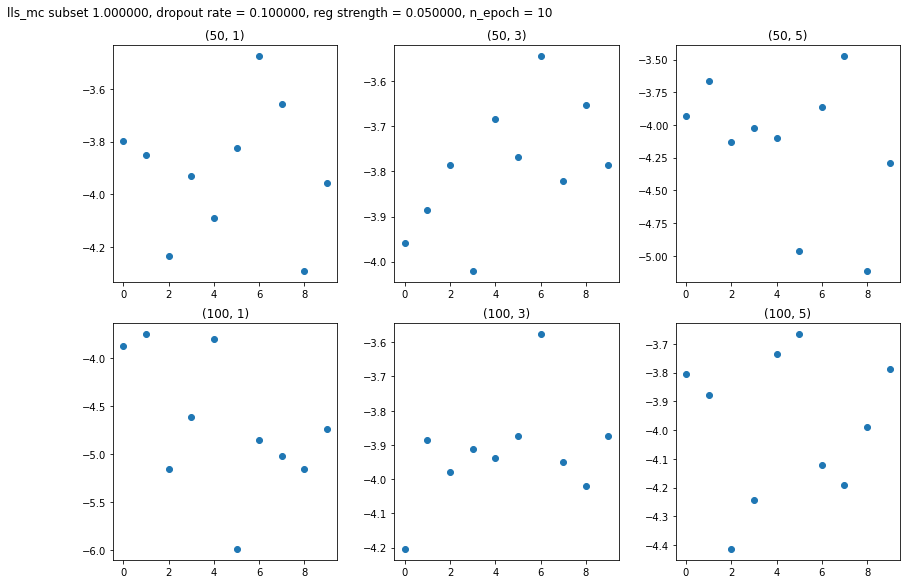

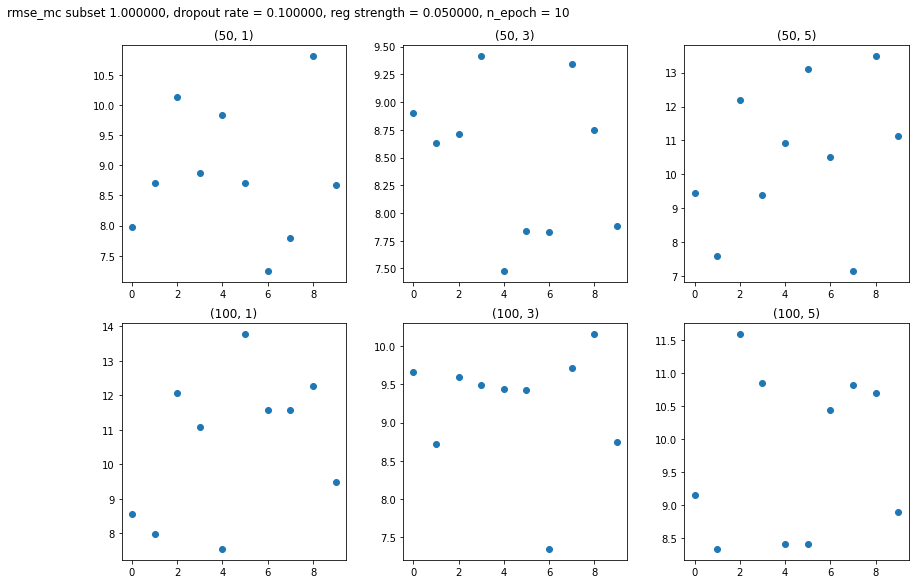

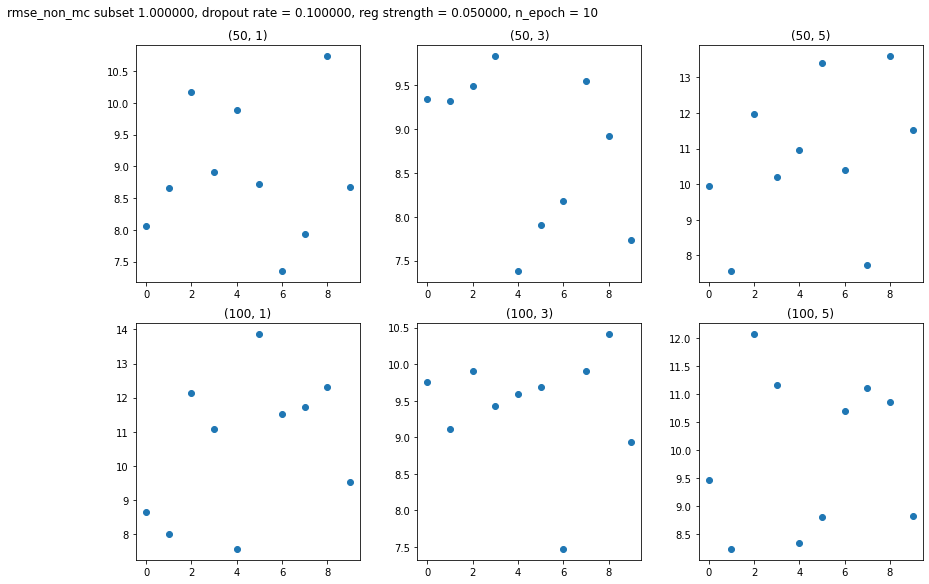

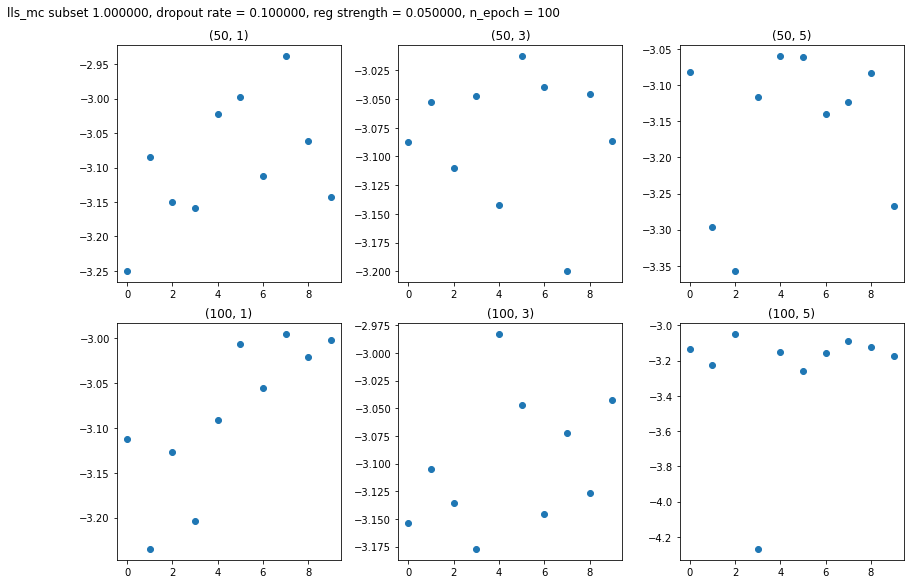

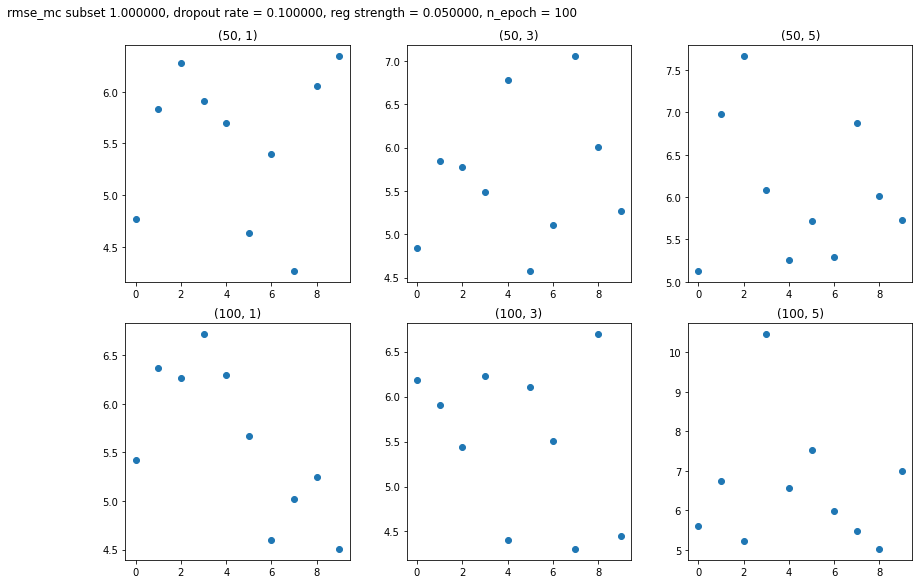

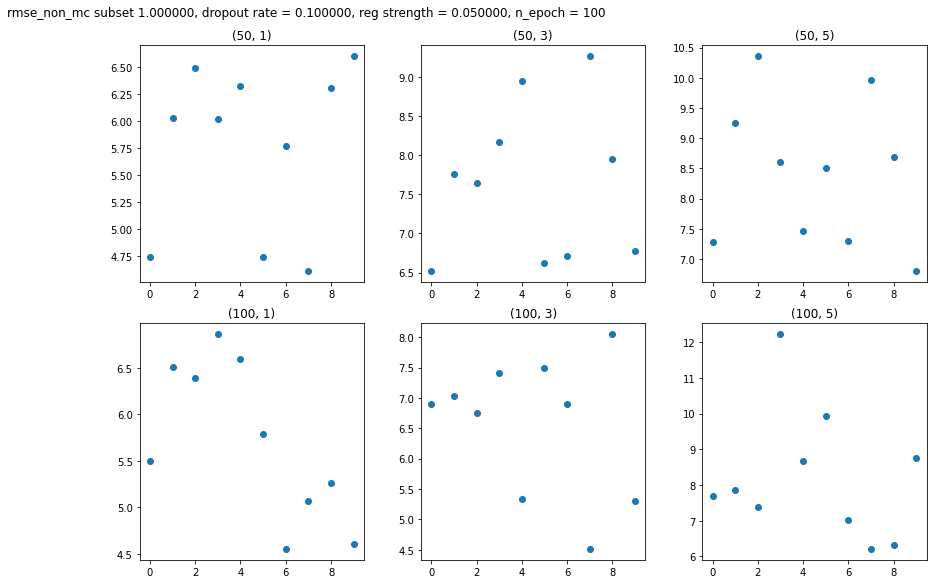

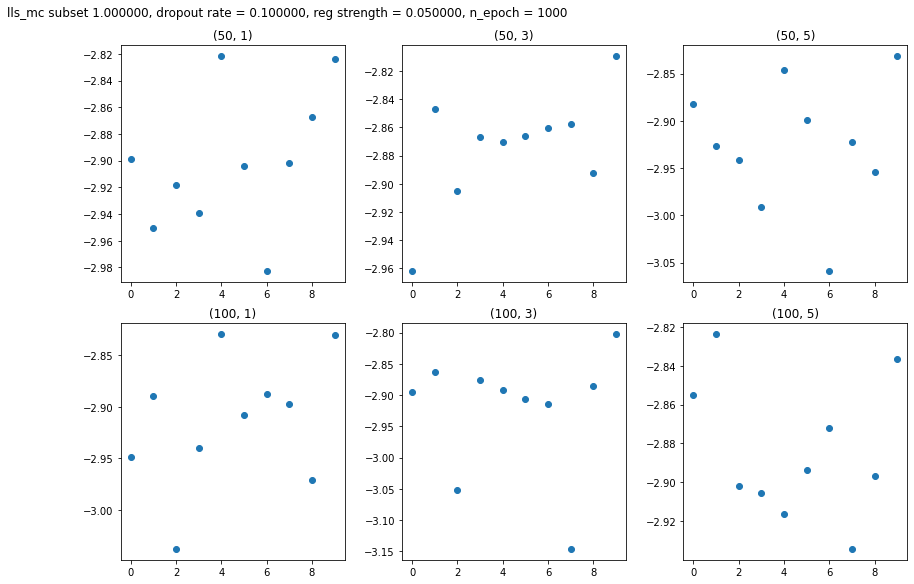

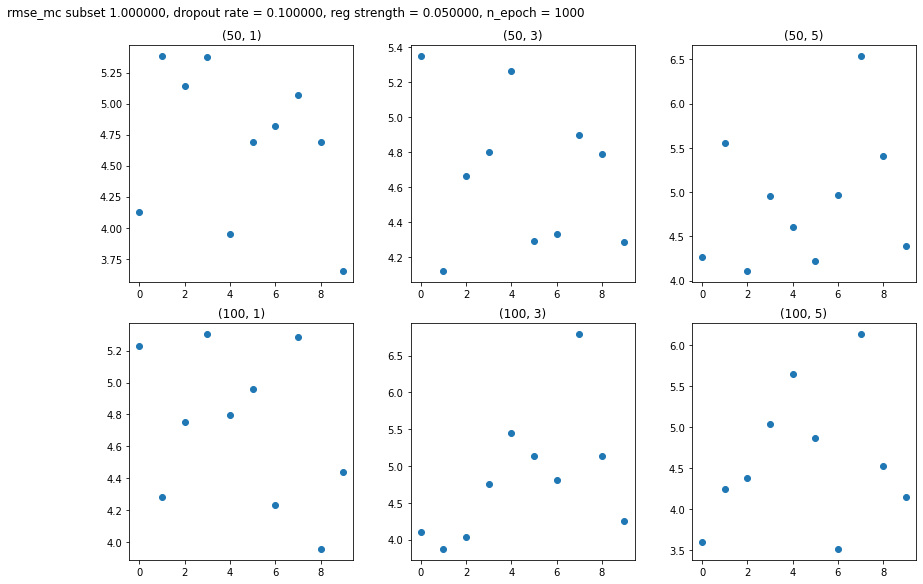

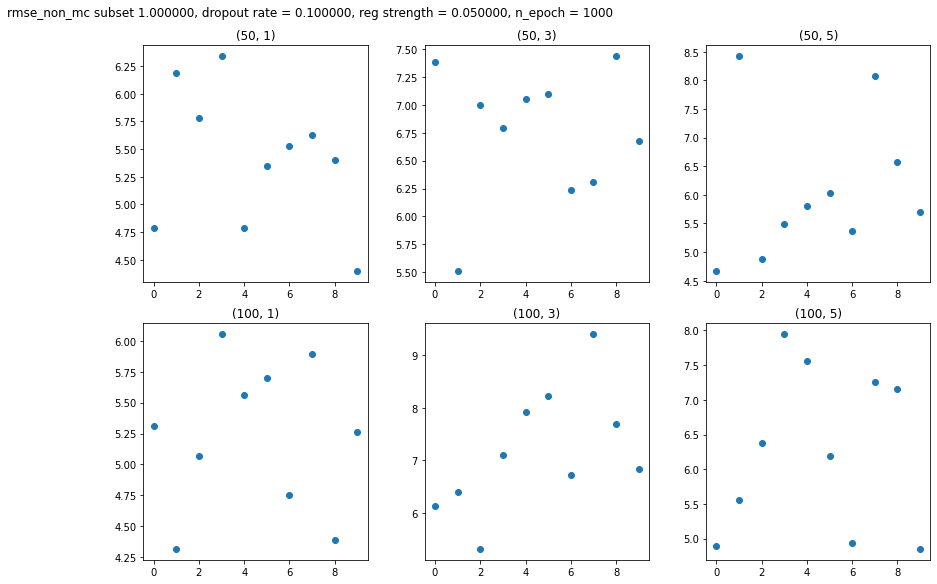

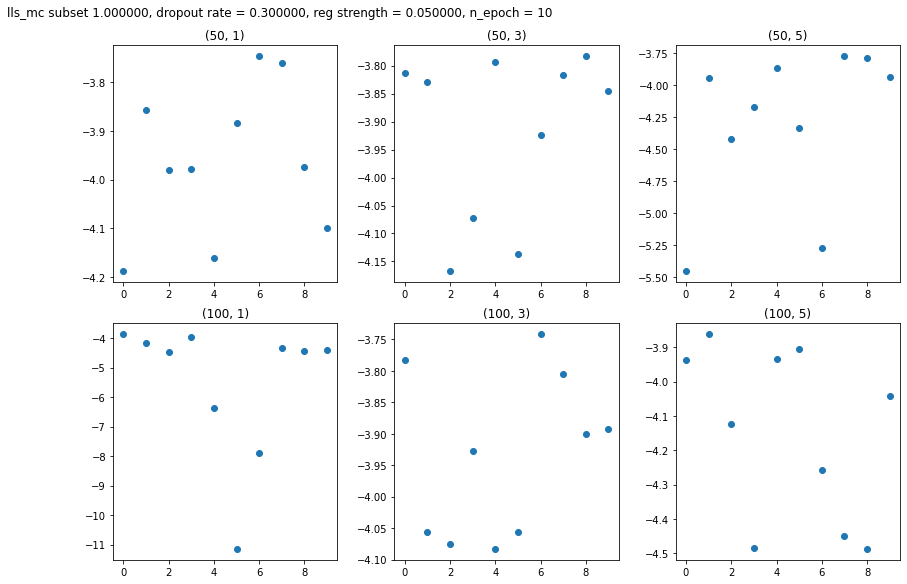

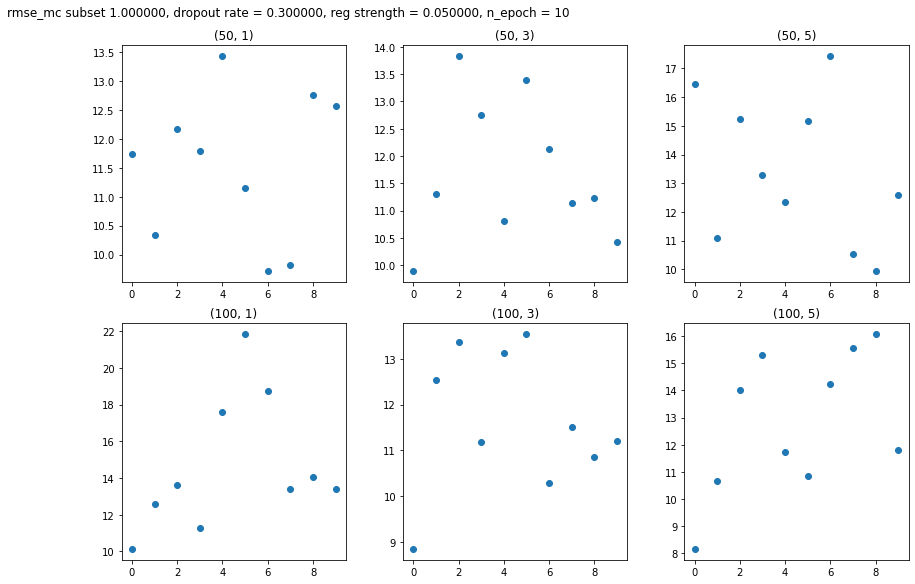

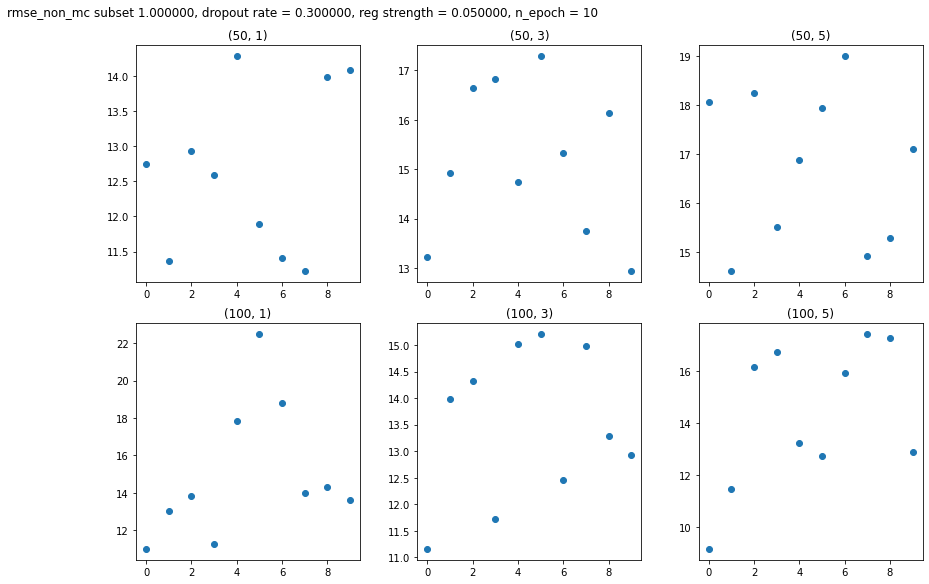

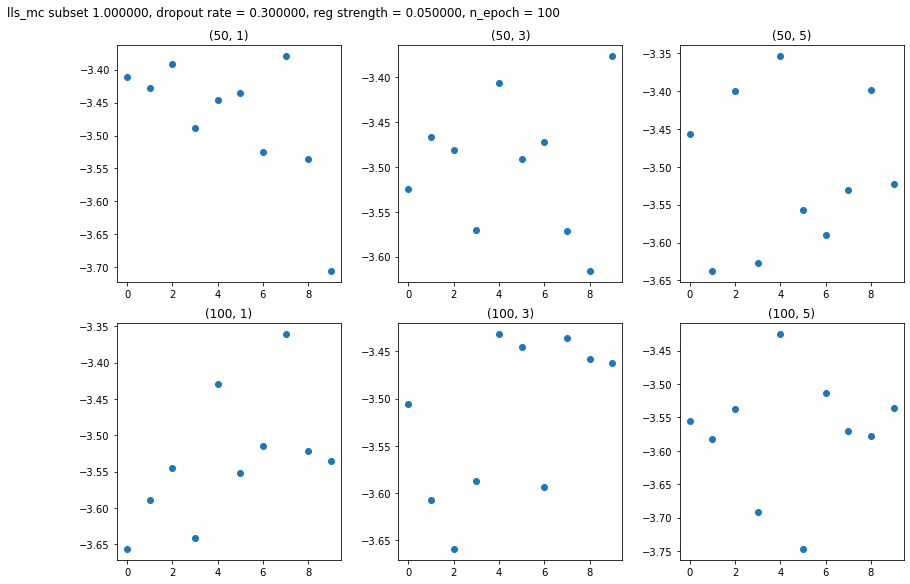

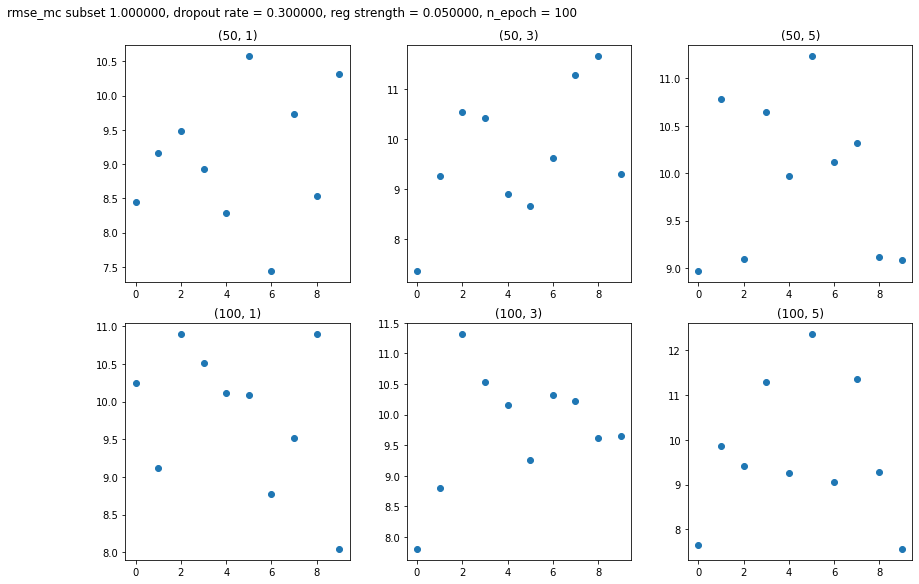

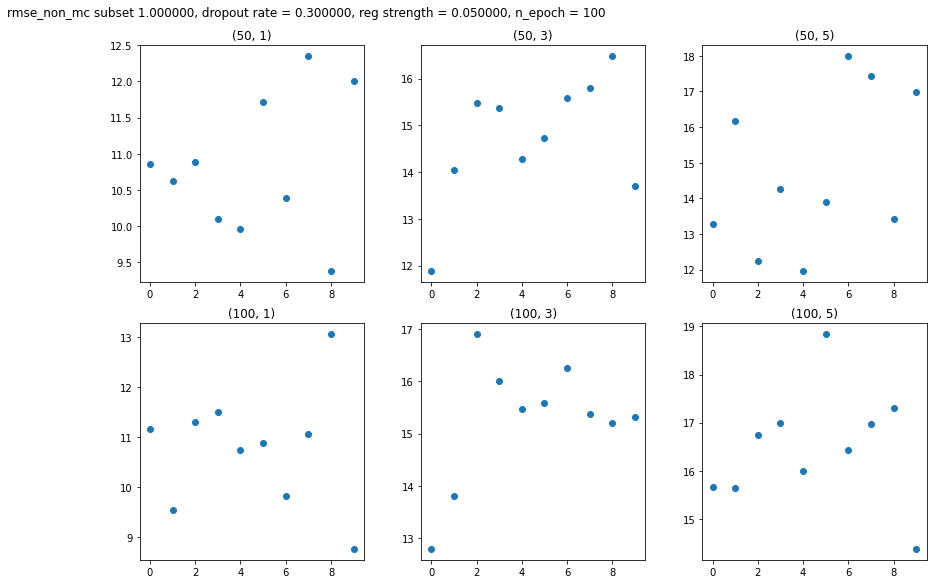

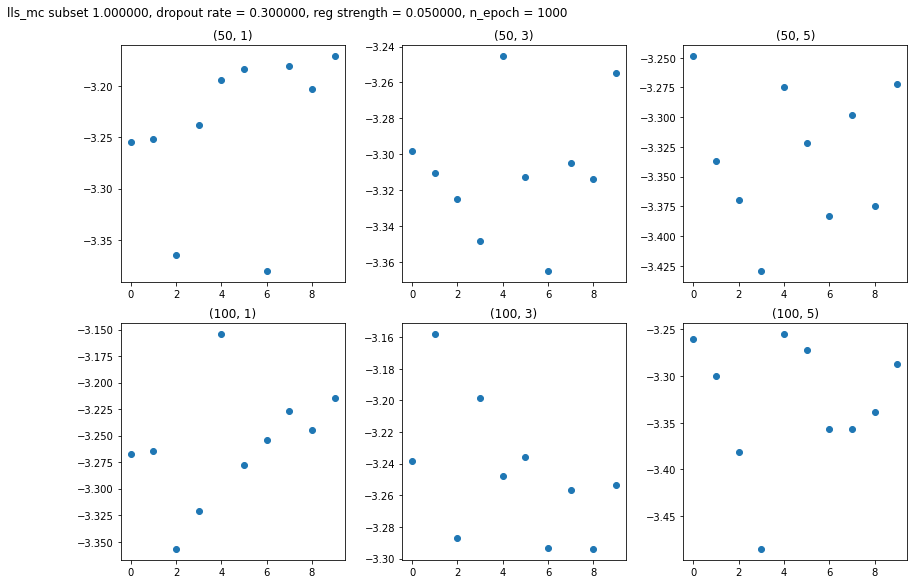

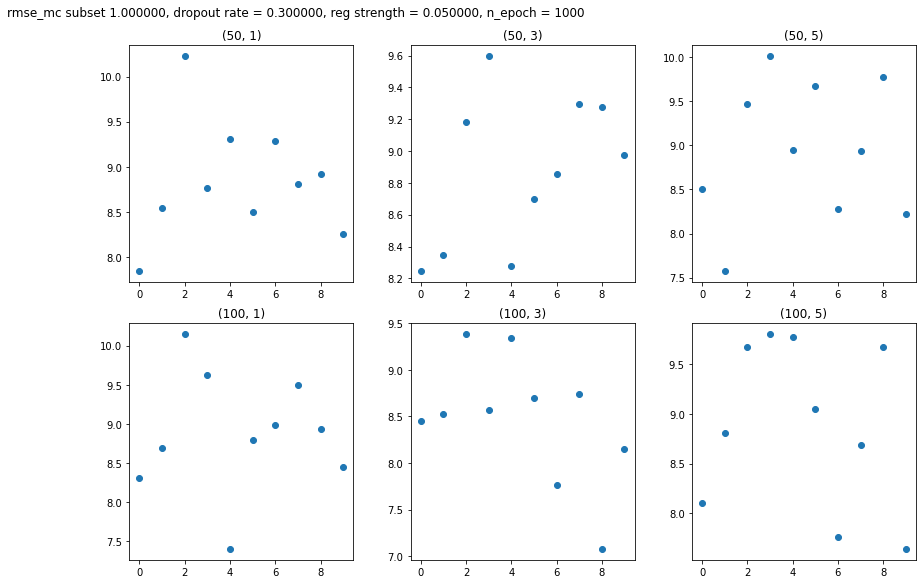

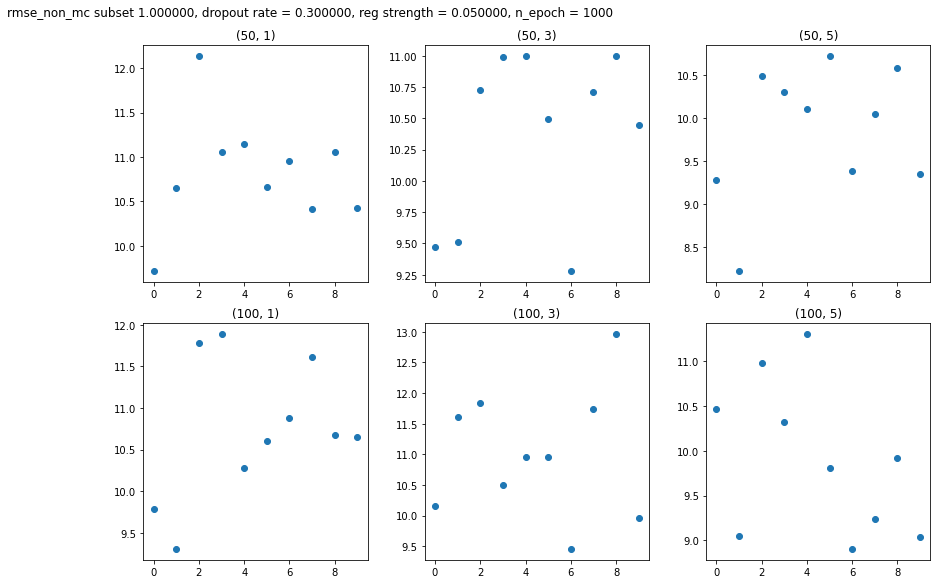

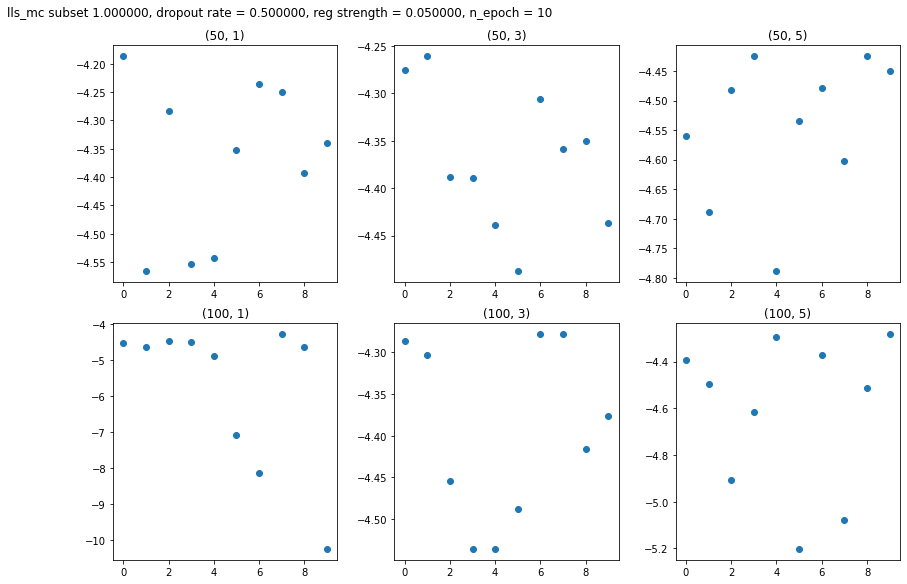

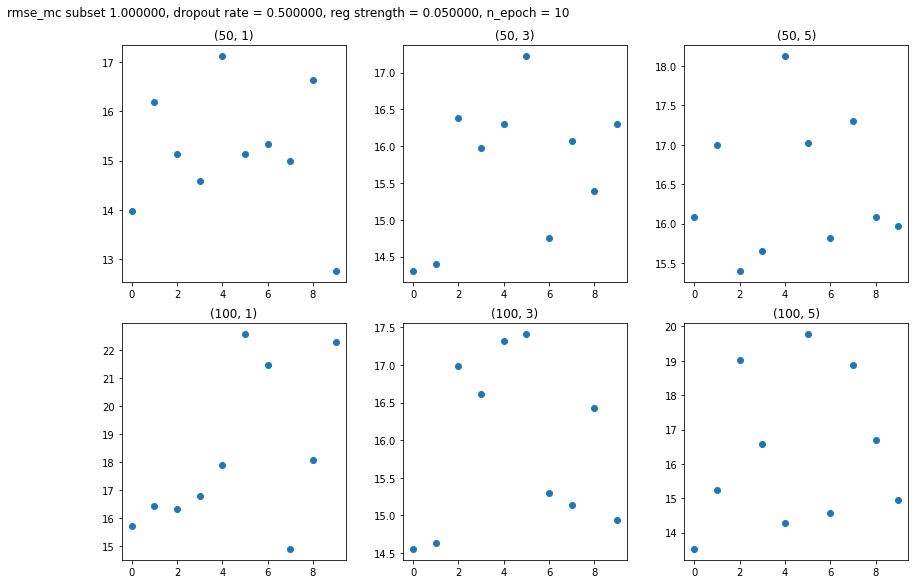

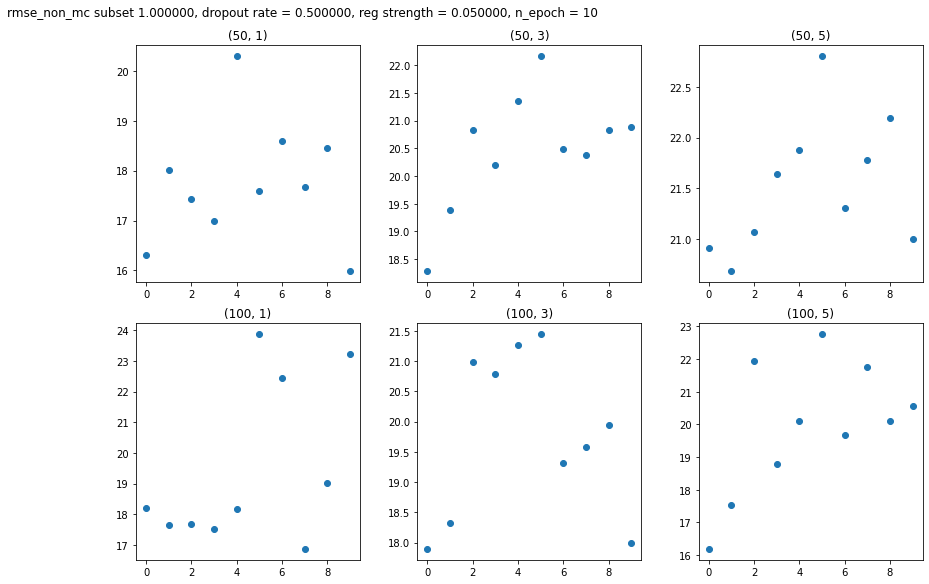

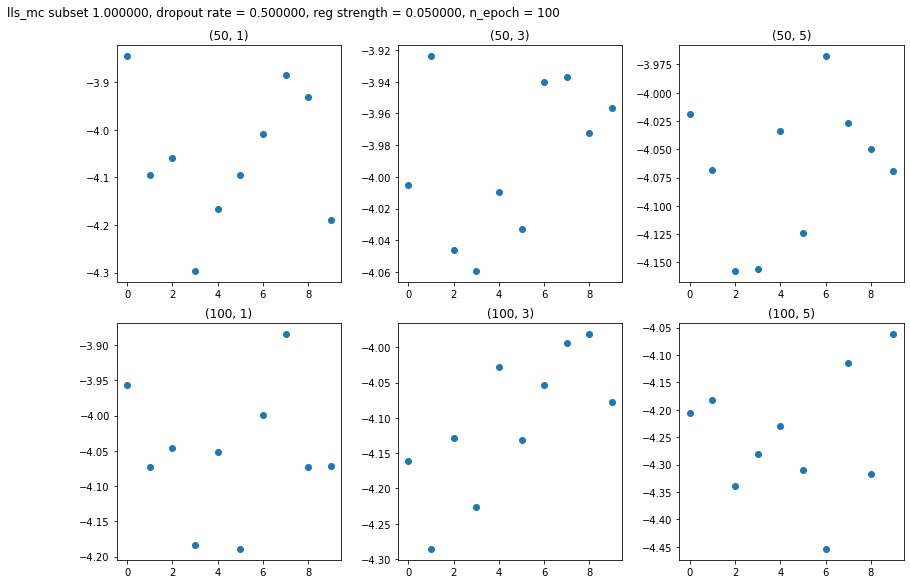

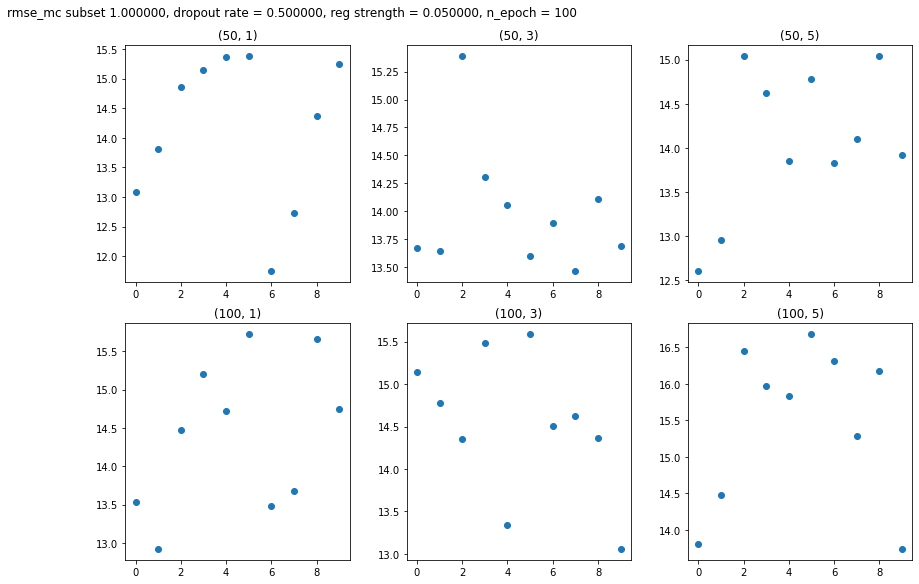

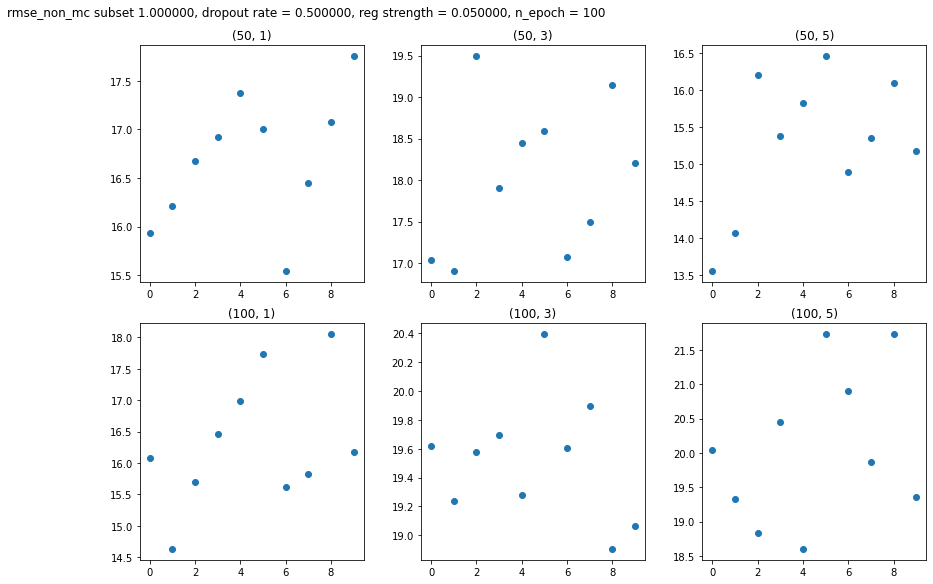

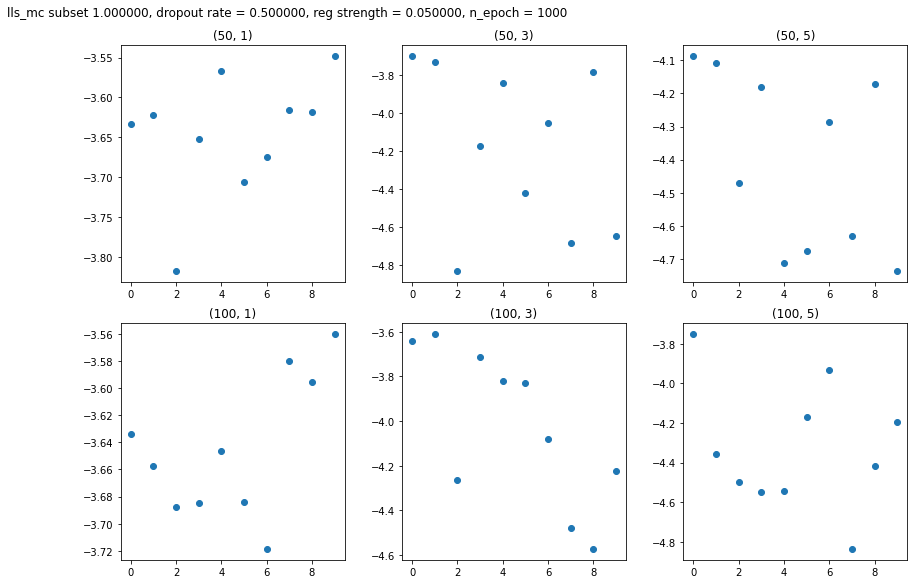

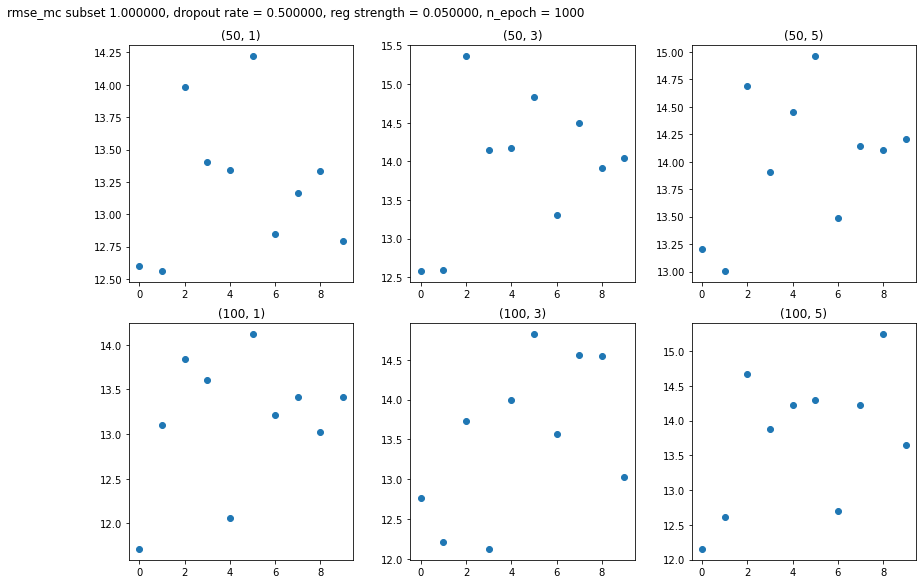

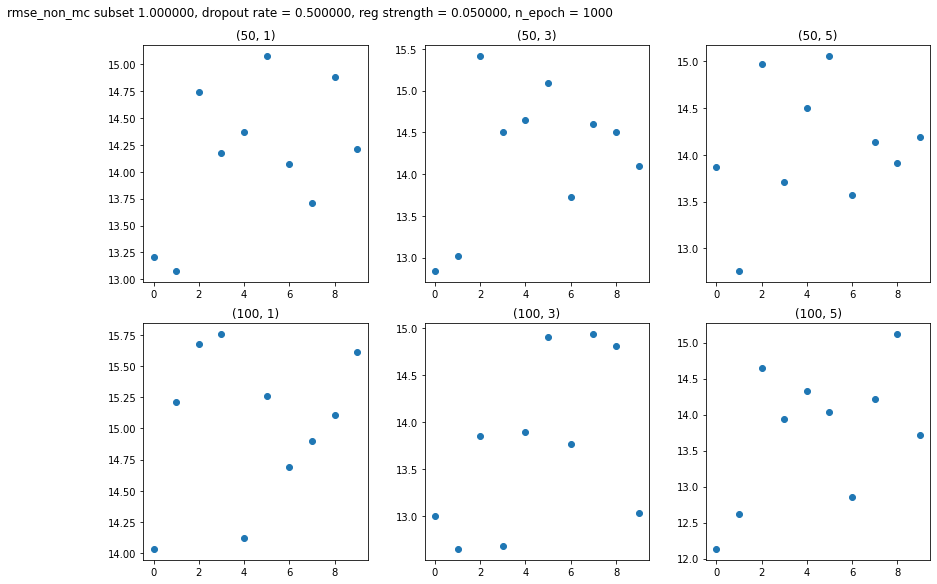

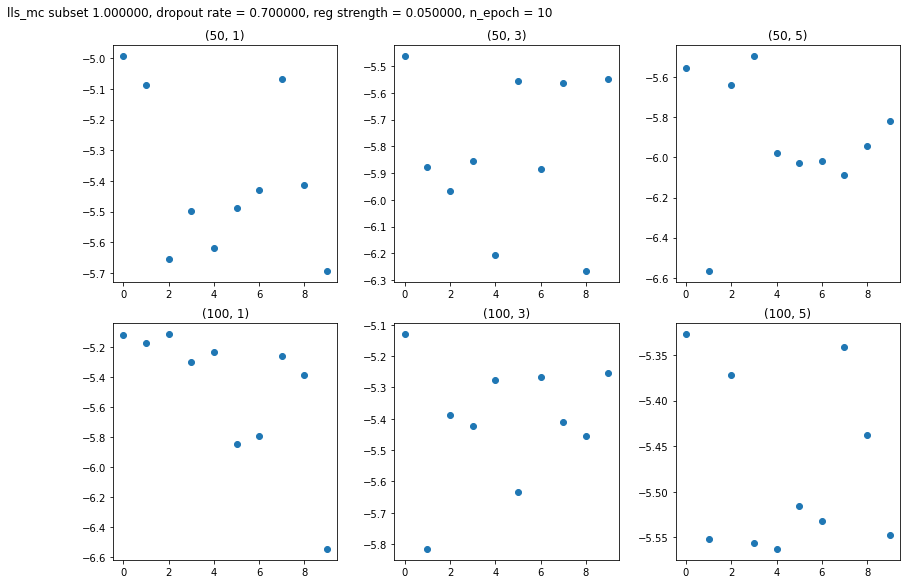

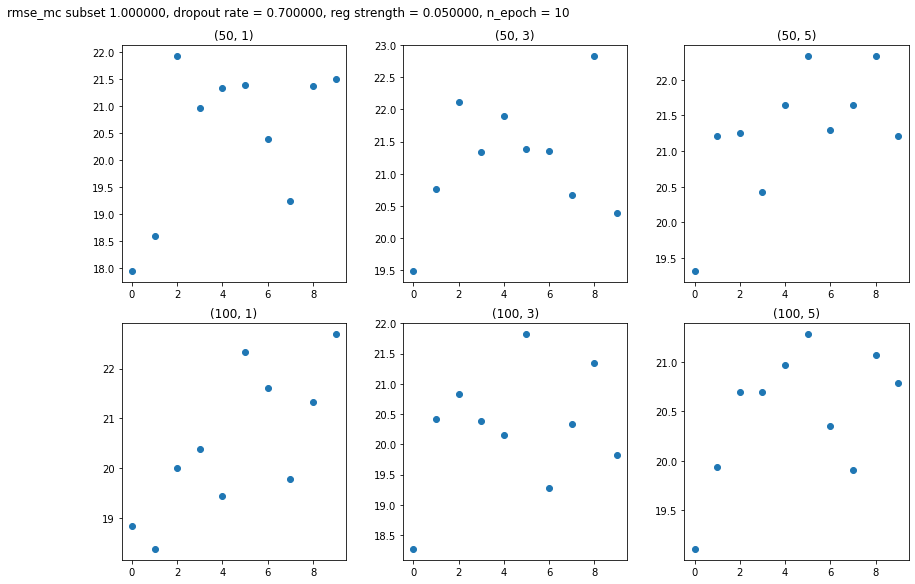

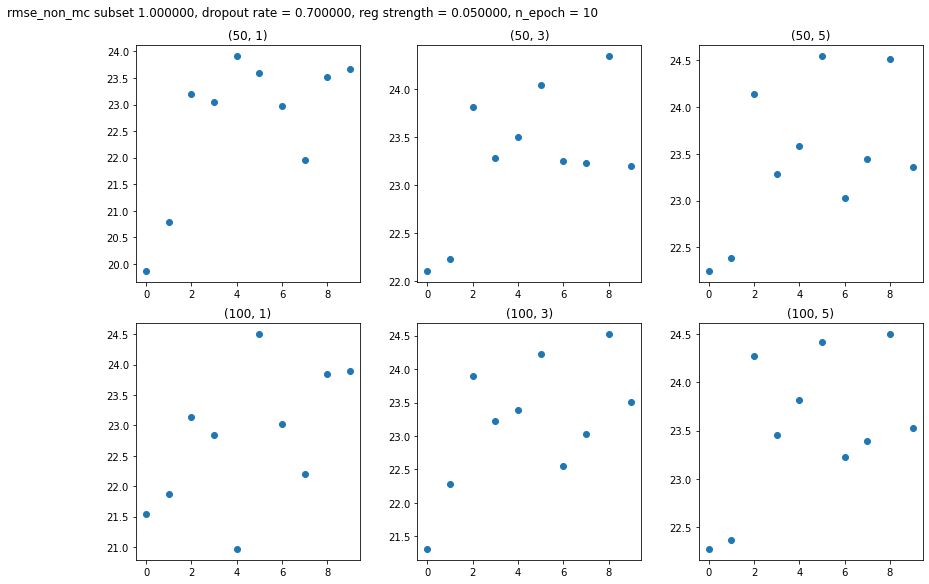

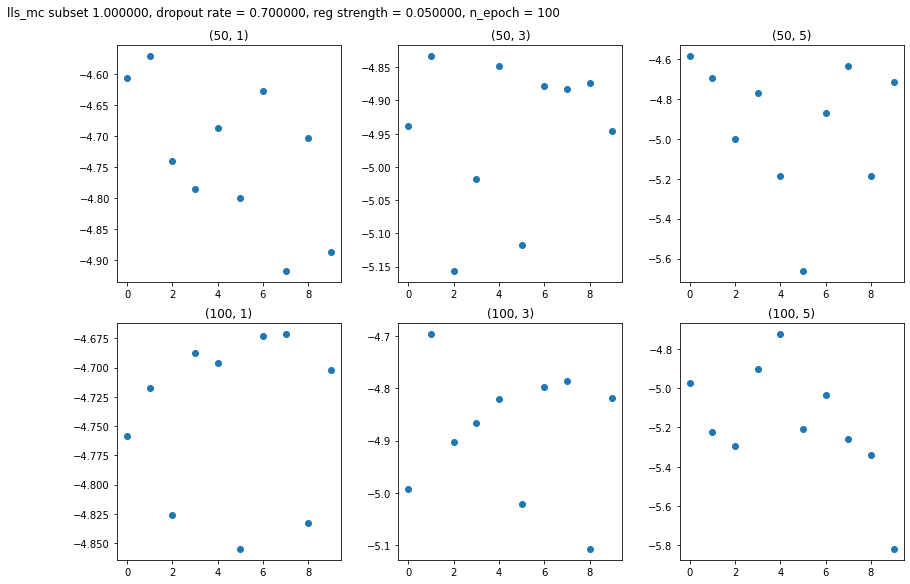

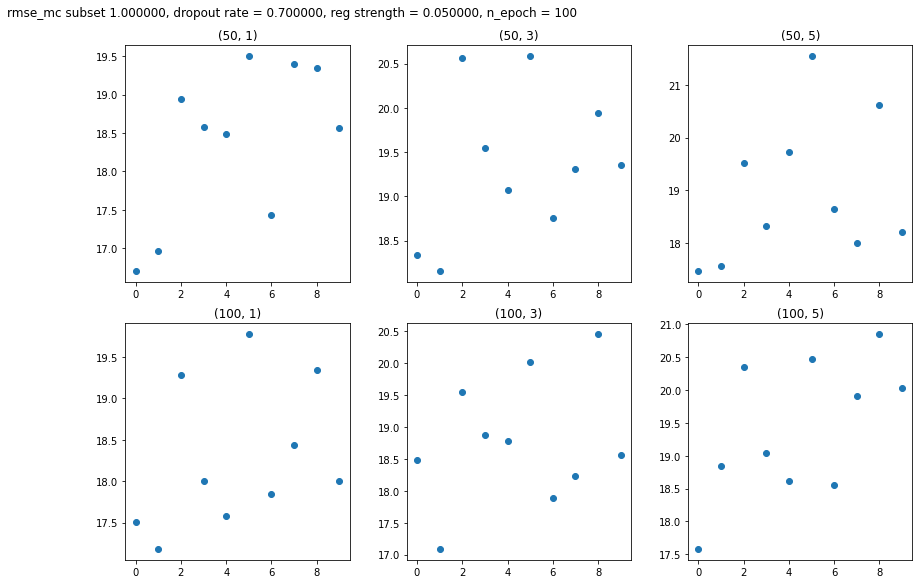

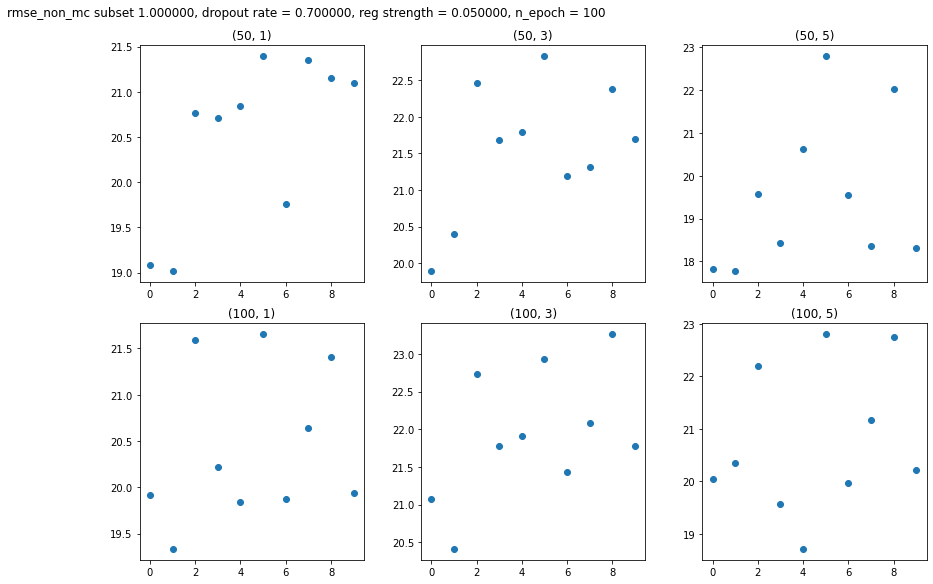

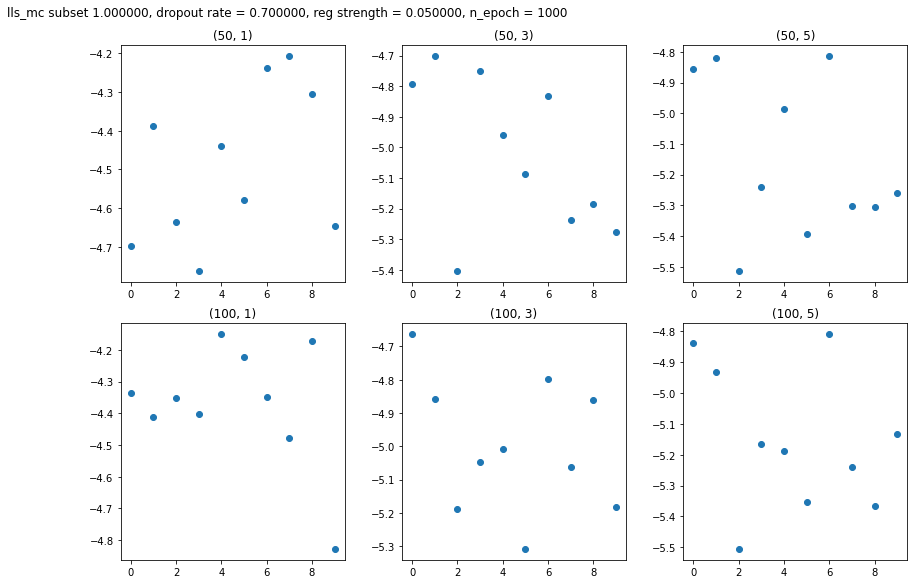

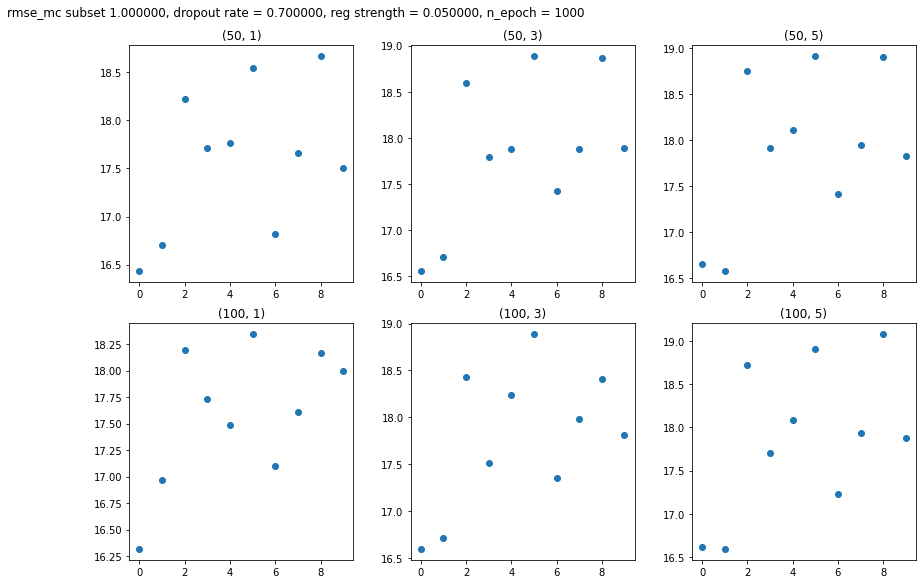

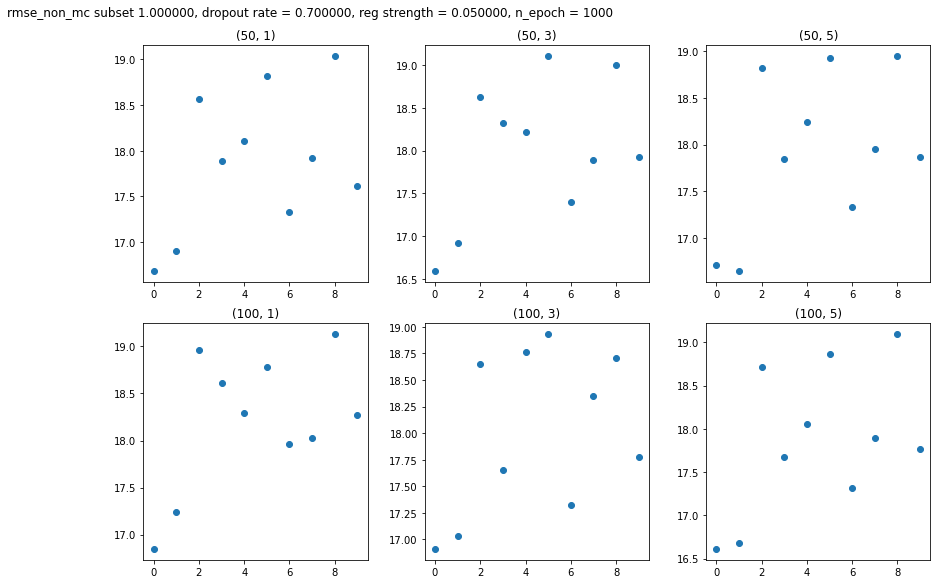

In [9]:
experiment_root_directory = os.path.join(
    './test_results',
    'error_convergence_1',
    uci_dataset_name,
    test_start_time,
)

for subset_prop, dropout_rate, reg_strength, n_epoch in itertools.product(
    subset_proportions, dropout_rates, reg_strengths, n_epochs
):
    for metric_name in ['lls_mc', 'rmse_mc', 'rmse_non_mc']:
        figure_file_name = (
            str(subset_prop)
            + '_' + str(dropout_rate)
            + '_' + str(reg_strength)
            + '_' + str(n_epoch)
            + '_' + metric_name + '.png'
        )
        
        figure_title = (
            metric_name 
            + (' subset %f, dropout rate = %f, reg strength = %f, n_epoch = %d' % (subset_prop, dropout_rate, reg_strength, n_epoch))
        )

        fig, ax = plt.subplots(len(network_hidden_dims), len(network_hidden_layers))

        fig.tight_layout(pad=2, rect=[0, 0.00, 2, 2])    

        plt_subplot_current_row = 0
        
        for hidden_dim in network_hidden_dims:
            plt_subplot_current_column = 0

            for n_layer in network_hidden_layers:
                # Open the score file
                score_file_path = os.path.join(
                    experiment_root_directory,
                    (
                        str(subset_prop) 
                        + '_' + str(hidden_dim)
                        + '_' + str(n_layer) 
                        + '_' + str(dropout_rate) 
                        + '_' + str(reg_strength)
                        + '_' + str(n_epoch)
                    ),
                    metric_name + '.txt',
                )

                scores = np.loadtxt(score_file_path).T
                
                #if metric_name in ('rmse_mc', 'rmse_non_mc'):
                #    ax[plt_subplot_current_row, plt_subplot_current_column].set_ylim([0, 20])
                #elif metric_name == 'lls_mc':
                #    ax[plt_subplot_current_row, plt_subplot_current_column].set_ylim([-20, 0])

                ax[plt_subplot_current_row, plt_subplot_current_column].scatter(scores[0], scores[1])

                ax[plt_subplot_current_row, plt_subplot_current_column].set_title(str((hidden_dim, n_layer)))

                plt_subplot_current_column += 1

            plt_subplot_current_row += 1

        fig.suptitle(figure_title, y=2.05)
        
        plt.savefig(
            os.path.join(experiment_root_directory, figure_file_name),
            dpi=600,
            bbox_inches='tight',
        )
        
        plt.show()